In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as  np
from scipy import signal
from scipy import fft
import scipy
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from ipywidgets import interactive
from IPython.display import HTML
import datetime
import math

In [91]:
data_path = "..\\Datasets\\Forecasting_aqua\\data_h_rolling_interpolated.csv"
format = "%d-%m-%Y"
df = pd.read_csv(data_path)
time_df = pd.to_datetime(df["Datetime"], infer_datetime_format=True)
try:
    df.drop("sample",axis=1,inplace=True)
except:
    pass
df['Datetime']= time_df
keys_imp = ['ciliate','mean_chla','cv_chla_day','cv_chla_depth',
            'nauplius','Ammonium','Nitrat','mean_schmidt','windspeed_max',
            'mean_thermocline_depth','mean_epi_temp','mean_oxycline_depth',
            'mean_mixed_layer_depth','mean_global_radiation'
           ]
df['year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
#drop the first datapoints the first months are only meteorological data
#first_point = (~df['mean_chla'].isnull()).idxmax()
#dfs = df.drop(index=range(first_point))
#df = dfs.reset_index(drop=True)

In [92]:
#prepare the tickslabels
months=[]
fday = []
for day in range(1,366):
    dstr = str(day)
    date = datetime.datetime.strptime("2019-" + dstr, "%Y-%j")
    months.append(date.strftime("%b"))
months,fday = np.unique(months,return_index=True)
#the months are not in order, but the ticks are still correct
print(months)
print(fday)

['Apr' 'Aug' 'Dec' 'Feb' 'Jan' 'Jul' 'Jun' 'Mar' 'May' 'Nov' 'Oct' 'Sep']
[ 90 212 334  31   0 181 151  59 120 304 273 243]


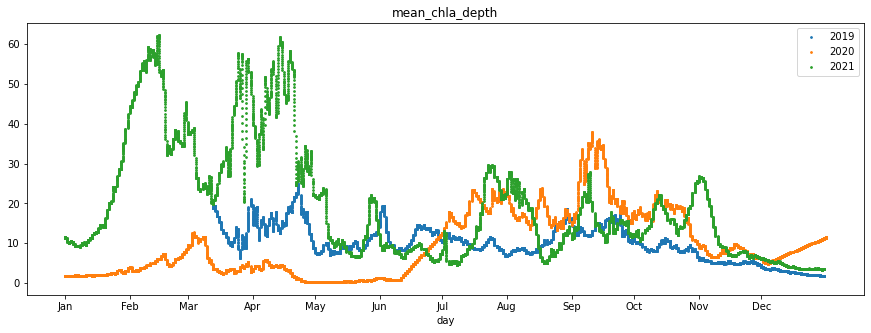

In [93]:
key = 'mean_chla_depth'
fig,ax = plt.subplots(1,figsize=(15,5))

years = df['year'].unique()
for year in years:
    dfy = df[df['year']==year]
    yeardt = np.datetime64(str(year),'Y')
    n_days = (dfy['Datetime']-yeardt).dt.days
    ax.scatter(n_days,dfy[key],s=3)
ax.legend([str(year) for year in years])
ax.set_title(key)
ax.set_xlabel("day")
ax.set_xticks(fday)
ax.set_xticklabels(months)
plt.show()

[]

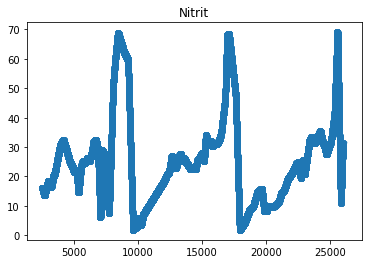

In [94]:
#interpolation
key='Nitrit'
#dfd = df.drop('Datetime',axis=1)
keys_float = df.keys().drop('Datetime')
dfci = df.copy()
dfcin = df.copy()
dfi = df[keys_float].interpolate(method='linear', limit_direction='forward', axis=0)
dfci[keys_float] = dfi-dfi.mean()
dfcin[keys_float] = dfci[keys_float]/dfci[keys_float].std()
dfci = dfci.fillna(0)
dfcin = dfcin.fillna(0)
plt.scatter(np.arange(len(df)),df[key])
plt.plot(np.arange(len(dfi)),dfi[key])
plt.title(key)
plt.plot()

## Fourier transform of each variable

In [95]:
#example of data recovery:
T = 365 # period 
N = 365*3+100
n = N-100
sin = np.array([
    math.sin(math.pi*x*2/T)
    for x in range(N)
])
ft_sine = scipy.fft.rfft(sin,n=n)

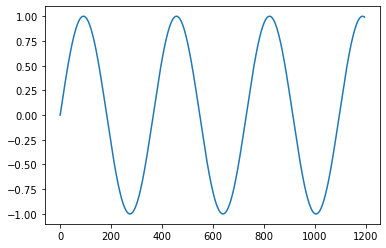

In [96]:
plt.plot(sin)

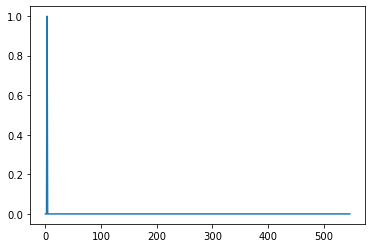

In [97]:
plt.plot(np.abs(ft_sine)/len(ft_sine))

In [98]:
(N)/np.argmax(np.abs(ft_sine))

398.3333333333333

The period is not perfectly recovered due to the finite number of points

In [99]:
len(dfcin)%365

24

In [100]:
ft = scipy.fft.rfft(dfcin[keys_float],axis=0)
fte = (ft*ft.conj()).real

In [101]:
idxk = {}
for idx, key in enumerate(keys_float):
    print(f"{idx}: {key}")
    idxk[key]=idx

0: mean_temp_depth
1: cv_temp
2: mean_condF_depth
3: cv_condF
4: mean_o2_depth
5: cv_o2
6: mean_o2ppm_depth
7: cv_o2ppm
8: mean_ph_depth
9: cv_ph
10: mean_chla_depth
11: cv_chla
12: mean_turb_depth
13: cv_turb
14: mean_par_depth
15: cv_par
16: mean_cloud_cover
17: mean_global_radiation
18: atmospheric_pressure_max
19: atmospheric_pressure_min
20: atmospheric_pressure_mean
21: temp_max
22: temp_min
23: temp_mean
24: precipitation_tot
25: rel_air_humidity_max
26: rel_air_humidity_min
27: rel_air_humidity_mean
28: sunshine_duration
29: windspeed_mean
30: windspeed_max
31: wind_direction_mean
32: mean_global_radiation_GR
33: atmospheric_pressure_max_GR
34: atmospheric_pressure_min_GR
35: atmospheric_pressure_mean_GR
36: temp_max_GR
37: temp_min_GR
38: temp_mean_GR
39: precipitation_tot_GR
40: rel_air_humidity_max_GR
41: rel_air_humidity_min_GR
42: rel_air_humidity_mean_GR
43: windspeed_mean_GR
44: windspeed_max_GR
45: wind_direction_mean_GR
46: Nitrat
47: Nitrit
48: Ammonium
49: oP
50: TP


C:\Users\valla\AppData\Local\Temp\ipykernel_11884\2084729060.py:11: RuntimeWarning: divide by zero encountered in log
  np.log(fte[1:max,idxk[key]]))


The main frequency component has a period of 30.4 days


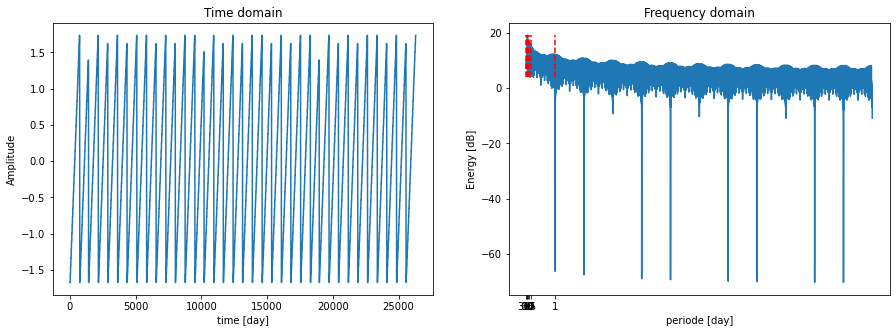

In [102]:
max=None
key = 'day'
fig,axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(dfcin[key])
axs[0].set_xlabel("time [day]")
axs[0].set_ylabel("Amplitude")
axs[0].set_title("Time domain")
freq = np.linspace(0.00000000001,1,fte.shape[0])
per = 1/freq #sampling period
axs[1].plot(freq[1:max],
            np.log(fte[1:max,idxk[key]]))
freq_lab = axs[1].get_xticks()
per_lab = np.array([1,7,10,15,30,60,365])
freq_ticks = [2/el/24 for el in per_lab]
axs[1].set_xticks(freq_ticks)
axs[1].set_xticklabels(per_lab)
axs[1].set_xlabel("periode [day]")
axs[1].set_ylabel("Energy [dB]")
axs[1].vlines(freq_ticks,
              np.min(np.log(fte[1:200,idxk[key]])),
              np.max(np.log(fte[1:200,idxk[key]])),
              color='r',linestyle='dashed')
axs[1].set_title("Frequency domain")
print("The main frequency component has a period of {:.1f}".format(len(dfci)/24/np.argmax(fte[:,idxk[key]]))
     +" days")

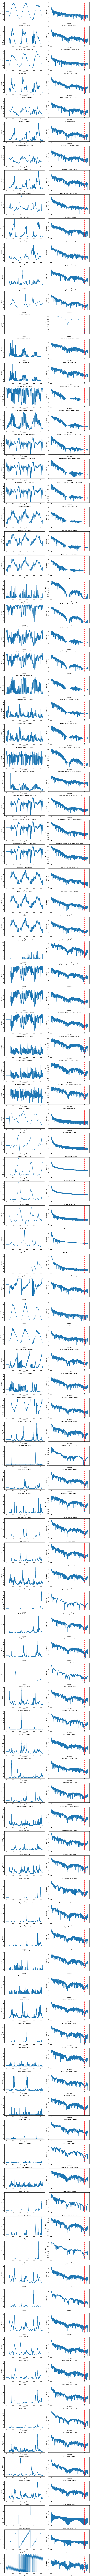

In [103]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('fourier_1droll.pdf')

max = 2400
fig,axs = plt.subplots(len(keys_float),2,figsize=(15,4*len(keys_float)),tight_layout=True)
freq = np.linspace(0.00000000001,1,fte.shape[0])
per = 1/freq
for idx,key in enumerate(keys_float):
    axs[idx][0].plot(dfcin[key])
    axs[idx][0].set_xlabel("time [hour]")
    axs[idx][0].set_ylabel("Amplitude")
    axs[idx][0].set_title(f"{key}: Time domain")
    
    axs[idx][1].plot(freq[1:max],
                np.log(fte[1:max,idxk[key]]))
    axs[idx][1].set_ylim(-5)
    freq_lab = axs[idx][1].get_xticks()
    per_lab = [0.5,1,365]
    freq_ticks = [2/el/24 for el in per_lab] #divide by 24 to get the time in units of days
    axs[idx][1].set_xticks(freq_ticks)
    axs[idx][1].set_xticklabels(per_lab)
    axs[idx][1].set_xlabel("periode [day]")
    axs[idx][1].set_ylabel("Energy [dB]")
    axs[idx][1].vlines(freq_ticks,
                       np.min(np.log(fte[1:max,idx])),
                       np.max(np.log(fte[1:max,idx])),
                       color='r',linestyle='dashed')
    axs[idx][1].set_title(f"{key}: Frequency domain")
pp.savefig()
pp.close()